In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
import seaborn as sns
import random

random.seed(10)


In [2]:
input_dir = r"/Users/juju/Library/Mobile Documents/com~apple~CloudDocs/ta_project/data/rdd_data"
output_dir = r"/Users/juju/Library/Mobile Documents/com~apple~CloudDocs/ta_project/output/demand"

In [3]:

df = pd.read_csv(os.path.join(input_dir,r"all_data.csv"))

In [4]:
df = df[df["year"]<=2016]

In [5]:
df_1 = df[(df["year"]>=2000)&(df["year"]<=2005)]
df_1["time_period"] = '2000-2005'
df_2 = df[(df["year"]>=2006)&(df["year"]<=2010)]
df_2["time_period"] = '2006-2010'
df_3 = df[(df["year"]>=2011)]
df_3["time_period"] = '2011-2016'
df = pd.concat([df_1,df_2,df_3],axis=0).reset_index()

/Users/juju/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/juju/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/juju/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

In [6]:

class_group_dict = {
    1:"luxury_group",
    2:"upscale_group",
    3:"upscale_group",
    4:"economy_group",
    5:"economy_group",
    6:"economy_group"    
}

In [7]:
df["Class Group"] = df["Class"].map(class_group_dict)

In [8]:
df["hotel_age"] = 2016 - df["OpenDate"]
df["hotel_age"] = df["hotel_age"].fillna(df["hotel_age"].mean())

In [9]:
# calculate market share

l=[]
for i in (0,1,2):
    
    data = df[df["Market"]==df["Market"].unique()[i]]
    
    test_1 = data.groupby(["month","year"])["Supply"].sum().reset_index().rename(columns={"Supply":"Market Monthly Supply"})
    test_7 = data.groupby(["month","year"])["Demand"].sum().reset_index().rename(columns={"Demand":"Market Monthly Demand"})
    test_2 = data.groupby(["month","year","Class Group"])["Demand"].sum().reset_index().rename(columns={"Demand":"Group Monthly Demand"})
    test_3 = data.groupby(["month","year"])["shareid"].nunique().reset_index().rename(columns={"shareid":"hotel_count_in_market"})
    #number of chain hotels
    test_4 = data[data["Operation"]==1].groupby(["month","year","Class Group"])["shareid"].nunique().reset_index().rename(columns={"shareid":"hotel_count_in_group_chain"})
    #number of franchised hotels
    test_5 = data[data["Operation"]==2].groupby(["month","year","Class Group"])["shareid"].nunique().reset_index().rename(columns={"shareid":"hotel_count_in_group_franchised"})
    #number of independent hotels
    test_6 = data[data["Operation"]==3].groupby(["month","year","Class Group"])["shareid"].nunique().reset_index().rename(columns={"shareid":"hotel_count_in_group_independent"})
    #number of hotel by size
    test_8_temp = data.groupby(["month","year","Class Group","SizeCode"])["shareid"].nunique()\
             .reset_index().rename(columns={"shareid":"hotel count"})
    test_8 = pd.pivot_table(data = test_8_temp,\
                            columns="SizeCode",\
                            index=["month","year","Class Group"],\
                            values = "hotel count").reset_index().rename_axis(None, axis=1)
    test_8 = test_8.rename(columns={1:"1_size", 2:"2_size",3:"3_size",4:"4_size",5:"5_size"})
    # hotel age
    test_9 = data.groupby(["month","year","Class Group"])["hotel_age"].mean().reset_index().rename(columns={"hotel_age":"Group Avg Age"})
   
    test = test_2.merge(test_4, on=["month","year", "Class Group"], how="left")\
                 .merge(test_5, on=["month","year", "Class Group"], how="left")\
                 .merge(test_6, on=["month","year", "Class Group"], how="left")\
                 .merge(test_8, on=["month","year", "Class Group"], how="left")\
                 .merge(test_9, on=["month","year", "Class Group"], how="left")\
                 .merge(test_1, on=["month","year"], how="left")\
                 .merge(test_7, on=["month","year"], how="left")\
                 .merge(test_3, on=["month","year"], how="left")
    
    temp = data.merge(test, on=["year","month","Class Group"], how="left")
    temp["market_share"] = temp["Demand"]/max(temp["Market Monthly Supply"])
    temp["group_share"] = temp["Demand"]/temp["Group Monthly Demand"]
    temp["s_0"] = 1- temp["Market Monthly Demand"]/max(temp["Market Monthly Supply"])
    

    l.append(temp)

df = pd.concat(l,axis=0).fillna(0).reset_index()    


In [10]:
#alpha = -0.014519850512492974
#sigma = 0.5141

alpha = -0.012
sigma = 0.5396

df["quality"] = np.log(df["market_share"])-np.log(df["s_0"])-sigma*np.log(df["group_share"])-alpha*df["ADR"]

In [11]:
df

,level_0,index,post_month,shareid,year_month,Supply,Demand,Revenue,Occ,ADR,...,4_size,5_size,Group Avg Age,Market Monthly Supply,Market Monthly Demand,hotel_count_in_market,market_share,group_share,s_0,quality
0,0,17,2001-01,80022,2001-01-01,3689.0,3588.0,82234.00,97.2621,22.919175,...,1.0,0.0,21.263255,813517.0,530982.0,148,0.002540,0.017088,0.624141,-3.033418
1,1,18,2001-02,80022,2001-02-01,3332.0,3263.0,76524.00,97.9291,23.452038,...,1.0,0.0,21.263255,734832.0,563836.0,148,0.002310,0.014698,0.600885,-3.002708
2,2,19,2001-03,80022,2001-03-01,3689.0,3588.0,85439.00,97.2621,23.812430,...,1.0,0.0,21.198012,822155.0,628642.0,149,0.002540,0.014049,0.555012,-2.799663
3,3,20,2001-04,80022,2001-04-01,3570.0,3429.0,81365.00,96.0504,23.728492,...,1.0,0.0,21.071522,802579.0,597992.0,152,0.002427,0.014090,0.576708,-2.885903
4,4,21,2001-05,80022,2001-05-01,3685.0,3587.0,86130.00,97.3405,24.011709,...,1.0,0.0,21.010194,831659.0,596021.0,153,0.002539,0.014336,0.578103,-2.849235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67665,16307,72809,2016-10,9990853,2016-10-01,12865.0,12529.0,3048074.00,97.3882,243.281507,...,8.0,3.0,18.866667,1210161.0,1027382.0,116,0.010353,0.083271,0.151037,1.580404
67666,16308,72810,2016-11,9990853,2016-11-01,12450.0,10838.0,2654683.00,87.0522,244.942148,...,8.0,3.0,17.687500,1185221.0,926959.0,119,0.008956,0.080494,0.234020,1.035767
67667,16309,72811,2016-12,9990853,2016-12-01,12865.0,9415.0,1328682.00,73.1830,141.123951,...,8.0,3.0,16.647059,1206439.0,683632.0,118,0.007780,0.091780,0.435090,-1.041757
67668,16310,72890,2016-11,10127842,2016-11-01,648.0,120.0,9363.02,18.5185,78.025167,...,0.0,1.0,31.615385,1185221.0,926959.0,119,0.000099,0.001339,0.234020,-3.260214


In [12]:
df["Rating"] = df["accum_rating"]*df["is_reviewed"]
df["ReviewCount_Reviewed"] = df["num_of_reviews"]*df["is_reviewed"]
df["Rating_ReviewCount_Reviewed"] = df["accum_rating"]*df["num_of_reviews"]*df["is_reviewed"]


In [13]:
# Create market year-month dummy

df["market_year_month"] = df["year_month"].astype(str) + df["Market"]


In [14]:
operation_dict = {
    1:"Chain_affiliated",
    2:"Chain_affiliated",
    3:"Independent",   
}

df["operation"] = df["Operation"].map(operation_dict)
df["operation_time_period"] = df["operation"]+'_'+df["time_period"]

In [15]:
list(df.columns)

['level_0',
 'index',
 'post_month',
 'shareid',
 'year_month',
 'Supply',
 'Demand',
 'Revenue',
 'Occ',
 'ADR',
 'RevPAR',
 'Country',
 'Market',
 'Chain',
 'Owner',
 'Mgmt',
 'ParentCompany',
 'Operation',
 'Scale',
 'Class',
 'Location',
 'OpenDate',
 'SizeCode',
 'max_str_month',
 'max_review_month',
 'min_review_month',
 'on_ta',
 'monthly_rating_mean',
 'monthly_review_count',
 'monthly_one_star_count',
 'monthly_two_star_count',
 'monthly_three_star_count',
 'monthly_four_star_count',
 'monthly_five_star_count',
 'monthly_hotel_response_count',
 'monthly_partnership_reviews_count',
 'cleanliness_count',
 'cleanliness_mean',
 'location_count',
 'location_mean',
 'sleep_quality_count',
 'sleep_quality_mean',
 'room_quality_count',
 'room_quality_mean',
 'service_count',
 'service_mean',
 'value_count',
 'value_mean',
 'renovate',
 'solo_count',
 'couple_count',
 'family_count',
 'business_count',
 'month_with_reviews',
 'num_of_reviews',
 'total_one_star',
 'total_two_star',
 'to

In [380]:

test = df[df["num_of_reviews"]!=0].groupby(["year_month"])["shareid"].nunique().reset_index().rename(columns={"shareid":"num_hotels_reviewed"})


test_2 = df.groupby(["year_month"])["shareid"].nunique().reset_index().rename(columns={"shareid":"num_hotels_total"})


penetration = test_2.merge(test, on=["year_month"], how="left").fillna(0)
 


In [381]:
df = df.merge(penetration, on=["year_month"], how="left")

In [382]:
df["penetration"]=df["num_hotels_reviewed"]*100/df["num_hotels_total"]
df["penetration"] = df["penetration"].fillna(0)

In [383]:
df["penetration"]

0        95.495495
1        95.067265
2        94.690265
3        94.759825
4        94.782609
           ...    
67665    96.000000
67666    96.033403
67667    96.016771
67668    96.033403
67669    96.016771
Name: penetration, Length: 67670, dtype: float64

Text(0.5, 1.0, 'Average occupancy rate for Chain-affiliated vs. Independent Hotels')

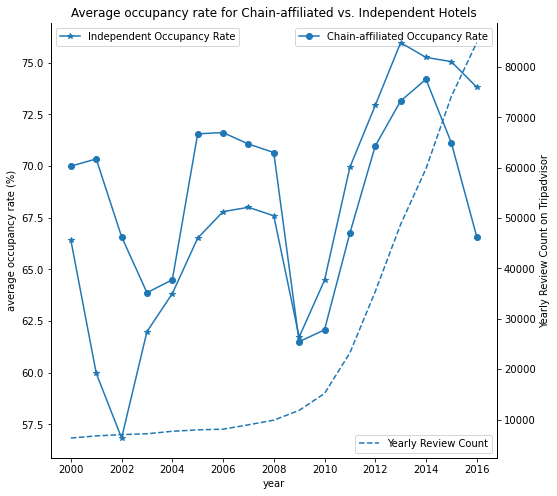

In [461]:
from matplotlib.dates import YearLocator, DateFormatter


fig, ax1 = plt.subplots(figsize=(8, 8))
ax2 = ax1.twiny()
ax3 = ax2.twinx()

df_chain = df[df["operation"]=="Chain_affiliated"]
df_ind = df[df["operation"]=="Independent"]

df_chain_rating = df_chain.groupby("year")["Occ"].mean().reset_index()
ax1.plot(df_chain_rating["year"],df_chain_rating["Occ"], marker = 'o',label = "Chain-affiliated Occupancy Rate" )
ax1.tick_params(axis='x', top = False, labeltop = False)
ax1.legend(loc="best")
ax1.set_xlabel(xlabel = "year")
ax1.set_ylabel(ylabel = "average occupancy rate (%)")

df_ind = df_ind.groupby("year")["Occ"].mean().reset_index()
ax2.plot(df_ind["year"],df_ind["Occ"], marker = '*',  label = "Independent Occupancy Rate")
ax2.tick_params(axis='x', top = False,labeltop = False)
ax2.legend(loc="best")


df_pen =df.groupby(["year"])["monthly_review_count"].sum().reset_index()
ax3.plot(df_pen["year"],df_pen["monthly_review_count"],linestyle='dashed',label = "Yearly Review Count")
ax3.tick_params(axis='x', top = False,labeltop = False)
ax3.legend(loc="lower right")
ax3.set_ylabel(ylabel = "Yearly Review Count on Tripadvisor")

plt.title("Average occupancy rate for Chain-affiliated vs. Independent Hotels")


In [452]:
df[df["on_ta"]==1][["monthly_review_count"]].describe()

,monthly_review_count
count,64438.000000
mean,6.562215
std,13.392028
min,0.000000
25%,1.000000
50%,1.000000
75%,6.000000
max,272.000000


In [456]:
df.groupby(["operation","Class Group"])["shareid"].nunique().reset_index().to_csv(r"count_chain.csv")

In [216]:
from statsmodels.api import add_constant
from linearmodels import IV2SLS
from statsmodels.iolib.summary2 import summary_col
import statsmodels.api as sm
import statsmodels
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing

OH = OneHotEncoder(handle_unknown='ignore')

fe_var= ["operation_time_period","operation","Market","time_period"]

x_fe = OH.fit_transform(df[fe_var]).toarray()
fe_var_cols = OH.fit(df[fe_var]).get_feature_names_out().tolist()

fe_var_df_1 = pd.DataFrame(x_fe, columns=fe_var_cols)



In [217]:
fe_var_df_1

,operation_time_period_Chain_affiliated_2000-2005,operation_time_period_Chain_affiliated_2006-2010,operation_time_period_Chain_affiliated_2011-2016,operation_time_period_Independent_2000-2005,operation_time_period_Independent_2006-2010,operation_time_period_Independent_2011-2016,operation_Chain_affiliated,operation_Independent,"Market_Chicago, IL","Market_Houston, TX","Market_Miami/Hialeah, FL",time_period_2000-2005,time_period_2006-2010,time_period_2011-2016
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67665,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
67666,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
67667,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
67668,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0


In [218]:
con_var_list = ["Rating", "is_reviewed"]
con_var_df = df[con_var_list]
x_temp = pd.concat([con_var_df,fe_var_df_1], axis=1).astype(float)
'''
x_temp["Chain_Rating"] = x_temp["operation_Chain"]*x_temp["Rating"]
x_temp["Franchise_Rating"] = x_temp["operation_Franchise"]*x_temp["Rating"]
x_temp["Independent_Rating"] = x_temp["operation_Independent"]*x_temp["Rating"]

x_temp["Economy_Rating"] = x_temp["Economy Class"]*x_temp["Rating"]
x_temp["Upscale_Rating"] = x_temp["Upscale Class"]*x_temp["Rating"]
x_temp["Luxury_Rating"] = x_temp["Luxury Class"]*x_temp["Rating"]

x_temp["Chicago_Rating"] = x_temp["Market_Chicago, IL"]*x_temp["Rating"]
x_temp["Houston_Rating"] = x_temp["Market_Houston, TX"]*x_temp["Rating"]
x_temp["Miami_Rating"] = x_temp["Market_Miami/Hialeah, FL"]*x_temp["Rating"]

x_temp["Chain_Chicago_Rating"] = x_temp["Market_Chicago, IL"]*x_temp["Chain_Rating"]
x_temp["Chain_Houston_Rating"] = x_temp["Market_Houston, TX"]*x_temp["Chain_Rating"]
x_temp["Chain_Miami_Rating"] = x_temp["Market_Miami/Hialeah, FL"]*x_temp["Chain_Rating"]

x_temp["Franchise_Chicago_Rating"] = x_temp["Market_Chicago, IL"]*x_temp["Franchise_Rating"]
x_temp["Franchise_Houston_Rating"] = x_temp["Market_Houston, TX"]*x_temp["Franchise_Rating"]
x_temp["Franchise_Miami_Rating"] = x_temp["Market_Miami/Hialeah, FL"]*x_temp["Franchise_Rating"]

x_temp["Independent_Chicago_Rating"] = x_temp["Market_Chicago, IL"]*x_temp["Independent_Rating"]
x_temp["Independent_Houston_Rating"] = x_temp["Market_Houston, TX"]*x_temp["Independent_Rating"]
x_temp["Independent_Miami_Rating"] = x_temp["Market_Miami/Hialeah, FL"]*x_temp["Independent_Rating"]


x_temp["Chain_Economy_Rating"] = x_temp["Economy Class"]*x_temp["Chain_Rating"]
x_temp["Chain_Upscale_Rating"] = x_temp["Upscale Class"]*x_temp["Chain_Rating"]
x_temp["Chain_Luxury_Rating"] = x_temp["Luxury Class"]*x_temp["Chain_Rating"]

x_temp["Franchise_Economy_Rating"] = x_temp["Economy Class"]*x_temp["Franchise_Rating"]
x_temp["Franchise_Upscale_Rating"] = x_temp["Upscale Class"]*x_temp["Franchise_Rating"]
x_temp["Franchise_Luxury_Rating"] = x_temp["Luxury Class"]*x_temp["Franchise_Rating"]

x_temp["Independent_Economy_Rating"] = x_temp["Economy Class"]*x_temp["Independent_Rating"]
x_temp["Independent_Upscale_Rating"] = x_temp["Upscale Class"]*x_temp["Independent_Rating"]
x_temp["Independent_Luxury_Rating"] = x_temp["Luxury Class"]*x_temp["Independent_Rating"]
'''

x_temp["2000-2005_Rating"] = x_temp["time_period_2000-2005"]*x_temp["Rating"]
x_temp["2006-2010_Rating"] = x_temp["time_period_2006-2010"]*x_temp["Rating"]
x_temp["2011-2016_Rating"] = x_temp["time_period_2011-2016"]*x_temp["Rating"]


x_temp["Chain_2000-2005_Rating"] = x_temp["operation_time_period_Chain_affiliated_2000-2005"]*x_temp["Rating"]
x_temp["Chain_2006-2010_Rating"] = x_temp["operation_time_period_Chain_affiliated_2006-2010"]*x_temp["Rating"]
x_temp["Chain_2011-2016_Rating"] = x_temp["operation_time_period_Chain_affiliated_2011-2016"]*x_temp["Rating"]

x_temp["Chain_Rating"] = x_temp["operation_Chain_affiliated"]*x_temp["Rating"]
x_temp["Chain_is_reviewed"] = x_temp["operation_Chain_affiliated"]*x_temp["is_reviewed"]

In [219]:

con_var_df = x_temp[["Rating","Chain_Rating", "is_reviewed"]]

fe_var= ["shareid","market_year_month"]

x_fe = OH.fit_transform(df[fe_var]).toarray()
fe_var_cols = OH.fit(df[fe_var]).get_feature_names_out().tolist()

fe_var_df_1 = pd.DataFrame(x_fe, columns=fe_var_cols)


x_1 = pd.concat([con_var_df,fe_var_df_1], axis=1)
x_1 = sm.add_constant(x_1)




In [220]:
'''
con_var_df = x_temp[["Luxury_Rating","Upscale_Rating","Economy_Rating",\
                    "is_reviewed","on_ta"]]

fe_var= ["shareid","market_year_month"]

x_fe = OH.fit_transform(df[fe_var]).toarray()
fe_var_cols = OH.fit(df[fe_var]).get_feature_names_out().tolist()

fe_var_df_1 = pd.DataFrame(x_fe, columns=fe_var_cols)


x_2 = pd.concat([con_var_df,fe_var_df_1], axis=1)
x_2 = sm.add_constant(x_2)

'''

'\ncon_var_df = x_temp[["Luxury_Rating","Upscale_Rating","Economy_Rating",                    "is_reviewed","on_ta"]]\n\nfe_var= ["shareid","market_year_month"]\n\nx_fe = OH.fit_transform(df[fe_var]).toarray()\nfe_var_cols = OH.fit(df[fe_var]).get_feature_names_out().tolist()\n\nfe_var_df_1 = pd.DataFrame(x_fe, columns=fe_var_cols)\n\n\nx_2 = pd.concat([con_var_df,fe_var_df_1], axis=1)\nx_2 = sm.add_constant(x_2)\n\n'

In [221]:
con_var_df = x_temp[[#"Chain_Rating","Franchise_Rating","Independent_Rating",\
                   # "Chicago_Rating","Houston_Rating","Miami_Rating",\
    #"Rating",\
                    "2000-2005_Rating","2006-2010_Rating","2011-2016_Rating",\
                   "Chain_2000-2005_Rating","Chain_2006-2010_Rating","Chain_2011-2016_Rating",\
                    "is_reviewed"]]

fe_var= ["shareid","market_year_month"]

x_fe = OH.fit_transform(df[fe_var]).toarray()
fe_var_cols = OH.fit(df[fe_var]).get_feature_names_out().tolist()

fe_var_df_1 = pd.DataFrame(x_fe, columns=fe_var_cols)


x_2 = pd.concat([con_var_df,fe_var_df_1], axis=1)
x_2 = sm.add_constant(x_2)



In [222]:
con_var_df = x_temp[[#"Chain_Rating","Franchise_Rating","Independent_Rating",\
                    #"Economy_Rating","Upscale_Rating","Luxury_Rating",\
   # "Rating",\
                    "2000-2005_Rating","2006-2010_Rating","2011-2016_Rating",\
                   "Chain_2000-2005_Rating","Chain_2006-2010_Rating","Chain_2011-2016_Rating",\
                    "is_reviewed"]]

fe_var= ["shareid","market_year_month","operation_time_period"]

x_fe = OH.fit_transform(df[fe_var]).toarray()
fe_var_cols = OH.fit(df[fe_var]).get_feature_names_out().tolist()

fe_var_df_1 = pd.DataFrame(x_fe, columns=fe_var_cols)


x_3 = pd.concat([con_var_df,fe_var_df_1], axis=1)
x_3 = sm.add_constant(x_3)



In [223]:
output_dir = r"/Users/juju/Library/Mobile Documents/com~apple~CloudDocs/ta_project/output/demand"

In [464]:
from statsmodels.iolib.summary2 import summary_col
from statsmodels.sandbox.regression.gmm import IV2SLS

y=df["quality"]

model_1 = sm.OLS(y, x_1)
results_1 = model_1.fit()

model_2 = sm.OLS(y, x_2)
results_2 = model_2.fit()

model_3 = sm.OLS(y, x_3)
results_3 = model_3.fit()

#model_4 = sm.OLS(y, x_4)
#results_4 = model_4.fit()
df["ln_ADR"] = np.log(df["ADR"])
model_4 = sm.OLS(df["ln_ADR"], x_1)
results_4 = model_4.fit()

model_5 = sm.OLS(df["ln_ADR"], x_2)
results_5 = model_5.fit()

model_6 = sm.OLS(df["ln_ADR"], x_3)
results_6 = model_6.fit()


res_main = summary_col([results_1,results_2, results_3,results_4, results_5, results_6], float_format = '%.3f', \
                  model_names = ["Q_jt (1)", 
                                "Q_jt (2)",
                                 "Q_jt (3)",
                                "log_ADR_jt (1)", 
                                 "log_ADR_jt (2)",
                                 "log_ADR_jt (3)"],\
                 regressor_order = ["Rating","Chain_Rating",
                                   "2000-2005_Rating","2006-2010_Rating","2011-2016_Rating",\
                                    "Chain_2000-2005_Rating","Chain_2006-2010_Rating","Chain_2011-2016_Rating",\
                                   "is_reviewed"],\
                  info_dict={'N':lambda x: "{0:d}".format(int(x.nobs)),
                           'Adjusted R-squared':lambda x: "{:.2f}".format(x.rsquared_adj)},\
                  stars = True,drop_omitted=True)


beginningtex = """\\documentclass{report}
\\usepackage{booktabs}
\\begin{document}"""
endtex = "\end{document}"

f = open(os.path.join(output_dir,'demand_fixed_effect_chain.tex'), 'w')
f.write(beginningtex)
f.write(res_main.as_latex())
f.write(endtex)
f.close()

# Reduced-form price

In [462]:
df["ln_ADR"] = np.log(df["ADR"])

In [131]:
from statsmodels.iolib.summary2 import summary_col
from statsmodels.sandbox.regression.gmm import IV2SLS

model_1 = sm.OLS(df["ln_ADR"], x_1)
results_1 = model_1.fit(cov_type="cluster",cov_kwds={"groups":df["shareid"]})

model_2 = sm.OLS(df["ln_ADR"], x_2)
results_2 = model_2.fit()

model_3 = sm.OLS(df["ln_ADR"], x_3)
results_3 = model_3.fit()

model_4 = sm.OLS(df["ln_ADR"], x_4)
results_4 = model_4.fit(cov_type="cluster",cov_kwds={"groups":df["shareid"]})

res_main = summary_col([results_1, results_2, results_3, results_4], float_format = '%.3f', \
                  model_names = ["log_ADR_jt (1)", 
                                 "log_ADR_jt (2)",
                                 "log_ADR_jt (3)",
                                "log_ADR_jt (4)"],\
                 regressor_order = ["Chain_Rating","Franchise_Rating","Independent_Rating",\
                                #    "Rating",\
                   "Economy_Rating","Upscale_Rating","Luxury_Rating",\
                    "Chain_Economy_Rating","Chain_Upscale_Rating","Chain_Luxury_Rating",\
                   "Franchise_Economy_Rating","Franchise_Upscale_Rating","Franchise_Luxury_Rating",\
                 "Independent_Economy_Rating","Independent_Upscale_Rating","Independent_Luxury_Rating"],\
                  info_dict={'N':lambda x: "{0:d}".format(int(x.nobs)),
                           'Adjusted R-squared':lambda x: "{:.2f}".format(x.rsquared_adj)},\
                  stars = True,drop_omitted=True)


beginningtex = """\\documentclass{report}
\\usepackage{booktabs}
\\begin{document}"""
endtex = "\end{document}"

f = open(os.path.join(output_dir,'price_fixed_effect_chain.tex'), 'w')
f.write(beginningtex)
f.write(res_main.as_latex())
f.write(endtex)
f.close()

In [16]:
df.to_csv(r"/Users/juju/Library/Mobile Documents/com~apple~CloudDocs/ta_project/data/welfare_data_test_ch3.csv", index= False)

In [55]:
df["ADR"].mean()

124.9342986554493